# Practical 4: Collaborative Filtering with Matrix Factorisation

### Neil D. Lawrence

### Radzim Sendyka

### 2025-09-09

**Abstract**: In this session we use our understanding of objective
functions to build a simple recommender system based on *matrix
factorisation*.

$$
$$

<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!---->
<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!-- The last names to be defined. Should be defined entirely in terms of macros from above-->
<!--

-->

## ML Foundations Course Notebook Setup

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_mlfc/includes/mlfc-notebook-setup.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_mlfc/includes/mlfc-notebook-setup.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

We install some bespoke codes for creating and saving plots as well as
loading data sets.

In [3]:
%%capture
%pip install notutils
%pip install pods
%pip install mlai

In [4]:
import notutils
import pods
import mlai
import mlai.plot as plot

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

<!--setupplotcode{import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set_palette('colorblind')}-->

Across the first week we motivated the importance of probability, but
also stressed that machine learning builds on ‘objective functions.’ In
this practical you will take the ideas you’ve learnt and apply them to
the domain of *collaborative filtering*. Specifically you will create a
*matrix factorisation* algorithm.

In the last few practicals we saw how we could load in a data set to
pandas and use it for some simple data processing. We computed variaous
probabilities on the data and I encouraged you to think about what sort
of probabilities you need for prediction. This week we are going to take
a slightly different tack.

Broadly speaking there are two dominating approaches to machine learning
problems. We started to consider both approaches last week: firstly we
can construct models based on defining the relationship between
variables using probabilities. In this practical we will consider the
second approach: which involves defining an *objective function* and
optimising it.

What do we mean by an objective function? An objective function could be
an *error function* a *cost function* or a *benefit* function. In
evolutionary computing they are called *fitness* functions. But the idea
is always the same. We write down a mathematical equation which is then
optimized to do the learning. The equation should be a function of the
*data* and our model *parameters*. We have a choice when optimizing,
either minimize or maximize. To avoid confusion, in the optimization
field, we always choose to minimize the function. If we have function
that we would like to maximize, we simply choose to minimize the
negative of that function.

So for this lab session, we are going to ignore probabilities, but don’t
worry, they will return!

This week we are going to try and build a simple movie recommender
system using an objective function. To do this, the first thing I’d like
you to do is to install some software we’ve written for sharing
information across google documents.

## Movie Violence Data

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_datasets/includes/movie-body-count-data.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_datasets/includes/movie-body-count-data.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

This is a data set created by Simon Garnier and Rany Olson for exploring
the differences between R and Python for data science. The data contains
information about different movies augmented by estimates about how many
on-screen deaths are contained in the movie. The data is craped from
<http://www.moviebodycounts.com>. The data contains the following
featuers for each movie: `Year`, `Body_Count`, `MPAA_Rating`, `Genre`,
`Director`, `Actors`, `Length_Minutes`, `IMDB_Rating`.

In [6]:
import pods

In [7]:
data = pods.datasets.movie_body_count()
movies = data['Y']

Acquiring resource: movie_body_count

Details of data: 
Data scraped from www.MovieBodyCounts.com and www.imdb.com using scripts provided on a github repository (in both Python and R) at https://github.com/morpionZ/R-vs-Python/tree/master/Deadliest%20movies%20scrape/code. This script pulls down the scraped data.

Please cite:
Simon Garnier and Randy Olson, Blog Post: R vs Python Round 2, February 2nd 2014 (http://www.theswarmlab.com/r-vs-python-round-2-22/)

After downloading the data will take up 536272 bytes of space.

Data will be stored in /root/ods_data_cache/movie_body_count.

Do you wish to proceed with the download? [yes/no]
YES
|    Downloading   0.366MB     |
|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>|


The data is provided to us in the form of a pandas data frame, we can
see the features we’re provided with by inspecting the columns of the
data frame.

In [8]:
print(', '.join(movies.columns))

Film, Year, Body_Count, MPAA_Rating, Genre, Director, Actors, Length_Minutes, IMDB_Rating


Once it is loaded in the data can be summarized using the `describe`
method in pandas.

## Plotting the Data

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_data-science/includes/movie-body-count-visualise.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_data-science/includes/movie-body-count-visualise.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

In [9]:
print(movies['Year'])
print(movies['Body_Count'])

0      2002
1      2007
2      2006
3      1999
4      1971
       ... 
416    2007
417    1967
418    2007
419    2001
420    1964
Name: Year, Length: 421, dtype: int64
0        7
1       45
2        0
3        7
4       10
      ... 
416     10
417     91
418      3
419      4
420    140
Name: Body_Count, Length: 421, dtype: int64


This shows the number of deaths per film across the years. We can plot
the data as follows.

In [10]:
# this ensures the plot appears in the web browser
%matplotlib inline
import matplotlib.pyplot as plt # this imports the plotting library in python

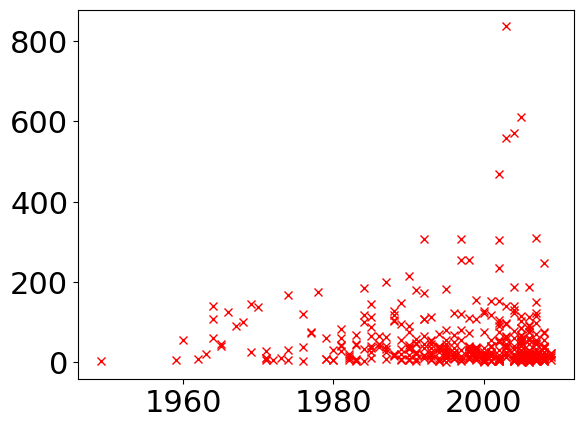

In [11]:
plt.plot(movies['Year'], movies['Body_Count'], 'rx')

You may be curious what the arguments we give to `plt.plot` are for, now
is the perfect time to look at the documentation

We immediately note that some films have a lot of deaths, which prevent
us seeing the detail of the main body of films. First lets identify the
films with the most deaths.

In [13]:
movies[movies['Body_Count']>200]

,Film,Year,Body_Count,MPAA_Rating,Genre,Director,Actors,Length_Minutes,IMDB_Rating
60,Dip huet gaai tau,1990,214,NaN,"[Crime, Drama, Thriller]",[John Woo],"[Tony Leung Chiu Wai, Jacky Cheung, Waise Lee,...",136,7.7
117,Equilibrium,2002,236,R,"[Action, Drama, Sci-Fi, Thriller]",[Kurt Wimmer],"[Christian Bale, Dominic Purcell, Sean Bean, C...",107,7.6
154,Grindhouse,2007,310,R,"[Action, Horror, Thriller]","[Robert Rodriguez, Eli Roth, Quentin Tarantino...","[Kurt Russell, Zoë Bell, Rosario Dawson, Vanes...",191,7.7
159,Lat sau san taam,1992,307,R,"[Action, Crime, Drama, Thriller]",[John Woo],"[Yun-Fat Chow, Tony Leung Chiu Wai, Teresa Mo,...",128,8.0
193,Kingdom of Heaven,2005,610,R,"[Action, Adventure, Drama, History, War]",[Ridley Scott],"[Martin Hancock, Michael Sheen, Nathalie Cox, ...",144,7.2
206,The Last Samurai,2003,558,R,"[Action, Drama, History, War]",[Edward Zwick],"[Ken Watanabe, Tom Cruise, William Atherton, C...",154,7.7
222,The Lord of the Rings: The Two Towers,2002,468,PG-13,"[Action, Adventure, Fantasy]",[Peter Jackson],"[Bruce Allpress, Sean Astin, John Bach, Sala B...",179,8.8
223,The Lord of the Rings: The Return of the King,2003,836,PG-13,"[Action, Adventure, Fantasy]",[Peter Jackson],"[Noel Appleby, Alexandra Astin, Sean Astin, Da...",201,8.9
291,Rambo,2008,247,R,"[Action, Thriller, War]",[Sylvester Stallone],"[Sylvester Stallone, Julie Benz, Matthew Marsd...",92,7.1
317,Saving Private Ryan,1998,255,R,"[Action, Drama, War]",[Steven Spielberg],"[Tom Hanks, Tom Sizemore, Edward Burns, Barry ...",169,8.6


Here we are using the command `movies['Kill_Count']>200` to index the
films in the pandas data frame which have over 200 deaths. To sort them
in order we can also use the `sort` command. The result of this command
on its own is a data series of `True` and `False` values. However, when
it is passed to the `data` data frame it returns a new data frame which
contains only those values for which the data series is `True`. We can
also sort the result. To sort the result by the values in the
`Kill_Count` column in *descending* order we use the following command.

In [14]:
movies[movies['Body_Count']>200].sort_values(by='Body_Count', ascending=False)

,Film,Year,Body_Count,MPAA_Rating,Genre,Director,Actors,Length_Minutes,IMDB_Rating
223,The Lord of the Rings: The Return of the King,2003,836,PG-13,"[Action, Adventure, Fantasy]",[Peter Jackson],"[Noel Appleby, Alexandra Astin, Sean Astin, Da...",201,8.9
193,Kingdom of Heaven,2005,610,R,"[Action, Adventure, Drama, History, War]",[Ridley Scott],"[Martin Hancock, Michael Sheen, Nathalie Cox, ...",144,7.2
382,Troy,2004,572,R,"[Adventure, Drama]",[Wolfgang Petersen],"[Julian Glover, Brian Cox, Nathan Jones, Adoni...",163,7.2
206,The Last Samurai,2003,558,R,"[Action, Drama, History, War]",[Edward Zwick],"[Ken Watanabe, Tom Cruise, William Atherton, C...",154,7.7
222,The Lord of the Rings: The Two Towers,2002,468,PG-13,"[Action, Adventure, Fantasy]",[Peter Jackson],"[Bruce Allpress, Sean Astin, John Bach, Sala B...",179,8.8
154,Grindhouse,2007,310,R,"[Action, Horror, Thriller]","[Robert Rodriguez, Eli Roth, Quentin Tarantino...","[Kurt Russell, Zoë Bell, Rosario Dawson, Vanes...",191,7.7
159,Lat sau san taam,1992,307,R,"[Action, Crime, Drama, Thriller]",[John Woo],"[Yun-Fat Chow, Tony Leung Chiu Wai, Teresa Mo,...",128,8.0
375,Titanic,1997,307,PG-13,"[Drama, Romance]",[James Cameron],"[Leonardo DiCaprio, Kate Winslet, Billy Zane, ...",194,7.7
406,We Were Soldiers,2002,305,R,"[Action, Drama, History, War]",[Randall Wallace],"[Mel Gibson, Madeleine Stowe, Greg Kinnear, Sa...",138,7.1
349,Starship Troopers,1997,256,R,"[Action, Sci-Fi]",[Paul Verhoeven],"[Casper Van Dien, Dina Meyer, Denise Richards,...",129,7.2


We now see that the ‘Lord of the Rings’ is a large outlier with a very
large number of kills. We can try and determine how much of an outlier
by histograming the data.

## Plotting the Data

Text(0.5, 1.0, 'Histogram of Film Kill Count')

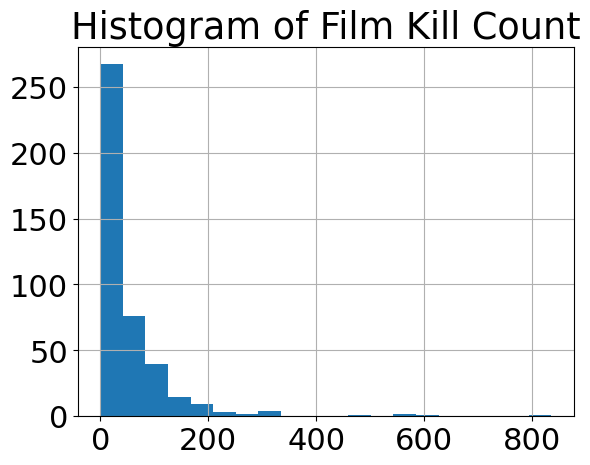

In [15]:
movies['Body_Count'].hist(bins=20) # histogram the data with 20 bins.
plt.title('Histogram of Film Kill Count')

### Exercise 1

Read on the internet about the following python libraries: `numpy`,
`matplotlib`, `scipy` and `pandas`. What functionality does each provide
python. What is the `pylab` library and how does it relate to the other
libraries?

NumPy – Provides fast multidimensional arrays and mathematical functions for numerical computing.

Matplotlib – A plotting library for visualizing data (line, scatter, bar, histograms, etc.).

SciPy – Builds on NumPy with advanced tools for optimization, integration, statistics, and signal processing.

Pandas – Offers Series and DataFrame for easy data manipulation, cleaning, and analysis.

Pylab – A convenience module combining NumPy and Matplotlib in a MATLAB-like style. Tries to mimic Matlab

### Exercise 1 Answer

Write your answer to Exercise 1 here

We could try and remove these outliers, but another approach would be
plot the logarithm of the counts against the year.

Text(0.5, 0, 'year')

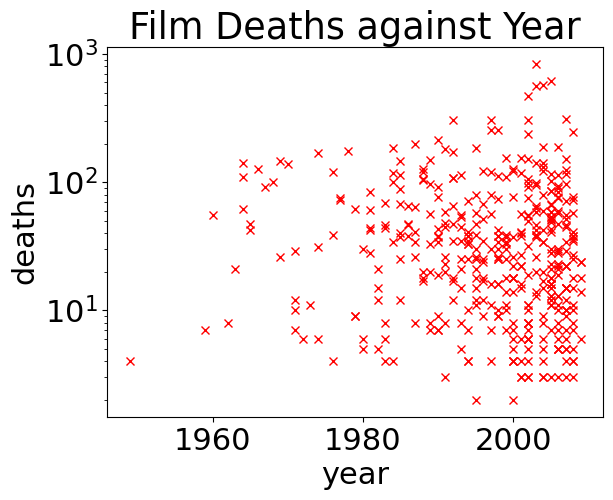

In [16]:
plt.plot(movies['Year'], movies['Body_Count'], 'rx')
ax = plt.gca() # obtain a handle to the current axis
ax.set_yscale('log') # use a logarithmic death scale
# give the plot some titles and labels
plt.title('Film Deaths against Year')
plt.ylabel('deaths')
plt.xlabel('year')

Note a few things. We are interacting with our data. In particular, we
are replotting the data according to what we have learned so far. We are
using the progamming language as a *scripting* language to give the
computer one command or another, and then the next command we enter is
dependent on the result of the previous. This is a very different
paradigm to classical software engineering. In classical software
engineering we normally write many lines of code (entire object classes
or functions) before compiling the code and running it. Our approach is
more similar to the approach we take whilst debugging. Historically,
researchers interacted with data using a *console*. A command line
window which allowed command entry. The notebook format we are using is
slightly different. Each of the code entry boxes acts like a separate
console window. We can move up and down the notebook and run each part
in a different order. The *state* of the program is always as we left it
after running the previous part.

### Exercise 2

Data ethics. If you find data available on the internet, can you simply
use it without consequence? If you are given data by a fellow researcher
can you publish that data on line?

### Exercise 2 Answer

Write your answer to Exercise 2 here

No, you cannot simply use data found online without consequence.
If a fellow researcher shares data with you, you cannot publish it online without their consent.

# Recommender Systems

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_ml/includes/recommender-systems.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_ml/includes/recommender-systems.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

A recommender system aims to make suggestions for items (films, books,
other commercial products) given what it knows about users’ tastes. The
recommendation engine needs to represent the *taste* of all the users
and the *characteristics* of each object.

A common way for organizing objects is to place related objects
spatially close together. For example in a library we try and put books
that are on related topics near to each other on the shelves. One system
for doing this is known as [Dewey Decimal
Classification](http://en.wikipedia.org/wiki/Dewey_Decimal_Classification).
In the Dewey Decimal Classification system (which dates from 1876) each
subject is given a number (in fact it’s a decimal number). For example,
the field of Natural Sciences and Mathematics is given numbers which
start with 500. Subjects based on Computer Science are given numbers
which start 004 and works on the ‘mathematical principles’ of Computer
science are given the series 004.0151 (which we might store as 4.0151 on
a Computer). Whilst it’s a classification system, the books in the
library are typically laid out in the same order as the numbers, so we
might expect that neighbouring numbers represent books that are related
in subject. That seems to be exactly what we want when also representing
films. Could we somehow represent each film’s subject according to a
number? In a similar way we could then imagine representing users with a
list of numbers that represent things that each user is interested in.

Actually a one dimensional representation of a subject can be very
awkward. To see this, let’s have a look at the Dewey Decimal
Classification numbers for the 900s, which is listed as ‘History and
Geography.’ We will focus on subjects in the 940s which can be found in
this list from [Nova Southeastern
University](http://www.nova.edu/library/help/misc/lc_dewey/dewey900.html#40).
Whilst the ordering for places is somewhat sensible, it is also rather
arbitrary. In the 940s we have Europe listed from 940-949, Asia listed
from 950-959 and Africa listed from 960-969. Whilst it’s true that Asia
borders Europe, Africa is also very close, and the history of the Roman
Empire spreads into [Carthage](http://en.wikipedia.org/wiki/Carthage)
and later on Egypt. This image from Wikipedia shows a map of the
Cathaginian Empire which fell after fighting with Rome.

<img class="" src="https://mlatcl.github.io/mlfc/./slides/diagrams//mlai/carthaginian-empire.png" style="width:60%">

Figure: <i>The Carthaginian Empire at its peak.</i>

We now need to make a decision about whether Roman Histories are
European or African, ideally we’d like them to be somewhere between the
two, but we can’t place them there in the Dewey Decimal system because
between Europe and Africa is Asia, which has less to do with the Roman
Empire than either Europe or Africa. Of course the fact that we’ve used
a map provides a clue as to what to do next. Libraries are actually laid
out on floors, so what if we were to use the spatial lay out to organise
the sujbects of the books in two dimensions. Books on Geography could be
laid out according to where in the world they are referring to.

Such complexities are very hard to encapsulate in one number, but
inspired by the map examples we can start considering how we might lay
out films in two dimensions. Similarly, we can consider laying out a map
of people’s interests. If the two maps correspond to one another, the
map of people could reflect where they might want to live in ‘subject
space.’ We can think of representing people’s tastes as where they might
best like to sit in the library to access easily the books they are most
interested in.

## Inner Products for Representing Similarity

Ideas like the above are good for gaining intuitions about what we might
want, but the one of the skills of data science is representing those
ideas mathematically. Mathematical abstraction of a problem is one of
the key ways in which we’ve been able to progress as a society.
Understanding planetary motions, as well as those of the smallest
molecule (to quote Laplace’s [Philosophical Essay on
Probabilities](http://books.google.co.uk/books?id=1YQPAAAAQAAJ&printsec=frontcover&source=gbs_ge_summary_r&cad=0#v=onepage&q&f=false))
needed to be done mathematically. The right mathematical model in
machine learning can be slightly more elusive, because constructing it
is a two stage process.

1.  We have to determine the right intuition for the system we want to
    represent. Notions such as ‘subject’ and ‘interest’ are not
    mathematically well defined, and even when we create a new
    interpretation of what they might mean, each interpretation may have
    its own weaknesses.

2.  Once we have our interpretation we can attempt to mathematically
    formalize it. In our library interpretation, that’s what we need to
    do next.

## The Library on an Infinite Plane

Let’s imagine a library which stores all the items we are interested in,
not just books, but films and shopping items too. Such a library is
likely to be very large, so we’ll create it on an infinite two
dimensional plane. This means we can use all the real numbers to
represent the location of each item on the plane. For a two dimensional
plane, we need to store the locations in a vector of numbers: we can
decide that the $j$th item’s location in the library is given by $$
\mathbf{v}_j = \begin{bmatrix} v_{j,1} \\ v_{j,2}\end{bmatrix},
$$ where $v_{j,1}$ represents the $j$th item’s location in the East-West
direction (or the $x$-axis) and $v_{j,2}$ represents the $j$th item’s
location in the North-South direction (or the $y$-axis). Now we need to
specify the location where each user sits so that all the items that
interest them are nearby: we can also represent the $i$th user’s
location with a vector $$
\mathbf{u}_i = \begin{bmatrix} u_{i,1} \\ u_{i,2}\end{bmatrix}.
$$ Finally, we need some way of recording a given user’s affinity for a
given item. This affinity might be the rating that the user gives the
film. We can use $y_{i,j}$ to represent user $i$’s affinity for item
$j$.

For our film example we might imagine wanting to order films in a few
ways. We could imagine organising films in the North-South direction as
to how romantic they are. We could place the more romantic films further
North and the less romantic films further South. For the East-West
direction we could imagine ordering them according to how historic they
are: we can imagine placing science fiction films to the East and
historical drama to the West. In this case, fans of historical romances
would be based in the North-West location, whilst fans of Science
Fiction Action films might be located in the South-East (if we assume
that ‘Action’ is the opposite of ‘Romance,’ which is not necessarily the
case). How do we lay out all these films? Have we got the right axes? In
machine learning the answer is to ‘let the data speak.’ Use the data to
try and obtain such a lay out. To do this we first need to obtain the
data.

## Collecting the Data

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_ml/includes/recommender-data.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_ml/includes/recommender-data.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

This functionality involves some prewritten code which connects to a
central write server, where you can rate movies that you’ve seen.

Once you have placed your ratings, we can download the data to a file.
We will build an algorithm on these ratings and use them to make
predictions for the rest of the class. Firstly, here’s the code for
which movies we will be rating. Remember to change your name.

In [19]:
import pandas as pd
import os
movies_list = [
    # Kenyan films
    "Nairobi Half Life",
    "Rafiki",
    "Sincerely Daisy",
    "Supa Modo",
    "Kati Kati",
    "Mvera",
    "NAWI: Dear Future Me",
    "BOBO",
    "The First Grader",
    "Mother Mother",
    "The Wall Street Boy",
    "40 Sticks",
    "TeraStorm",

    # Global all-time blockbuster hits
    "Avatar",
    "Avengers: Endgame",
    "Titanic",
    "The Lion King",
    "Frozen",
    "Spider-Man: No Way Home",
    "Black Panther",
    "Top Gun: Maverick",
    "The Dark Knight",
    "Inception",
    "Jurassic World",
    "Minions: The Rise of Gru",
    "The Fate of the Furious",
    "Doctor Strange in the Multiverse of Madness",
    "Furious 7",
    "Star Wars: The Force Awakens",
    "The Avengers",
    "Beauty and the Beast",
    "Harry Potter and the Deathly Hallows – Part 2",
    "Joker",
    "Aladdin",
    "Aquaman"
]

name = 'Betty' # TODO: replace 'Betty' with your name - this will be somewhat public so you might not want to use full real names, nickname is fine

The below code starts an interactive Python Widget, which will submit
your responses. There’s also code for reading the ratings after they’ve
been submitted.

In [20]:
import random, requests, ipywidgets as W
from ipywidgets import Widget
from IPython.display import display, clear_output
import json

# Config
topic, target = "mlfc_movie_ratings", 25
url = f"https://ntfy.sh/{topic}"
cache = "rated_movies_cache.txt"

def responses(topic=topic, sep="|||", since="all", n=None):
    url = f"https://ntfy.sh/{topic}/json?poll=1&since={since}"
    rows = []
    with requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            if not line: continue
            e = json.loads(line)
            if e.get("event") != "message": continue
            p = (e.get("message") or "").split(sep)
            rows.append({"user": p[0], "film": p[1], "rating": pd.to_numeric(p[2], errors="coerce")} if len(p)==3 else {"raw": e.get("message")})
            if n and len(rows) >= n: break
    return pd.DataFrame(rows)

def start_movie_rater(movies_list=movies_list, topic=topic, name=name, target=25):
    import random, requests
    import ipywidgets as W
    from IPython.display import display

    url = f"https://ntfy.sh/{topic}"
    movies = list(dict.fromkeys(map(str, movies_list)))
    seen = set()  # in-memory only
    rated, cur, running = 0, None, True

    def rem(): return [m for m in movies if m not in seen]
    def mark_seen(m):
        if m not in seen:
            seen.add(m)
    def send(m, r):
        try:
            requests.post(url, data=f"{name}|||{m}|||{r}".encode("utf-8"), timeout=3)
        except Exception:
            pass

    status = W.HTML()
    btns = [W.Button(description=str(i)) for i in range(1, 11)]
    skip = W.Button(description="Skip", button_style="warning")
    finish = W.Button(description="Finish", button_style="success")
    box = W.VBox([status, W.HBox(btns + [skip, finish])])

    def end(msg):
        nonlocal running
        running = False
        for w in btns + [skip, finish]:
            w.disabled = True
        status.value = msg

    def pick_next():
        nonlocal cur
        r = rem()
        cur = random.choice(r) if r else None
        status.value = f"<b>Rate ({rated}/{target}):</b> {cur}" if cur else ""

    def on_rate(b):
        nonlocal rated
        if not running or cur is None:
            return
        send(cur, int(b.description))
        mark_seen(cur)
        rated += 1
        if rated >= target:
            end(f"Done. Rated {rated}.")
            return
        pick_next()
        if cur is None:
            end(f"No unseen movies left. Rated {rated}.")

    def on_skip(_):
        if not running or cur is None:
            return
        mark_seen(cur)
        pick_next()
        if cur is None:
            end(f"No unseen movies left. Rated {rated}.")

    def on_finish(_):
        end(f"Finished. Rated {rated}.")

    for b in btns:
        b.on_click(on_rate)
    skip.on_click(on_skip)
    finish.on_click(on_finish)

    display(box)
    pick_next()
    if cur is None:
        end("No unseen movies to rate.")

In [21]:
# run this cell to provide your ratings
Widget.close_all()
start_movie_rater(target=5)

In [22]:
# run this cell to collect everyone's responses
Y = responses()
Y

,user,film,rating
0,fred,The Fate of the Furious,3
1,fred,Frozen,4
2,fred,Avengers: Endgame,9
3,fred,Joker,8
4,fred,Aladdin,5
...,...,...,...
123,Betty,The Avengers,9
124,Betty,Avengers: Endgame,6
125,Betty,Aquaman,7
126,Betty,Mvera,4


## Processing the Data

### Exercise 3

What is a pivot table? What does the `pandas` command `pd.pivot_table`
do? Subsequently, what does `pd.melt` do?

### Exercise 3 Answer

Write your answer to Exercise 3 here

A pivot table is a data summarization tool that allows you to reorganize, group, and aggregate data.

pd.pivot_table: Creates a pivot table from a DataFrame.

pd.melt: Does the opposite — it “un-pivots” or reshapes wide-format data back into a long/tidy format.

### Exercise 4

Convert the above DataFrame `Y` to a pivot table, and then back again to
its current form.

In [25]:
# Write your answer to Exercise 4 here
pivot = pd.pivot_table(Y, index="user", columns="film", values="rating", aggfunc="sum")
Y

,user,film,rating
0,fred,The Fate of the Furious,3
1,fred,Frozen,4
2,fred,Avengers: Endgame,9
3,fred,Joker,8
4,fred,Aladdin,5
...,...,...,...
123,Betty,The Avengers,9
124,Betty,Avengers: Endgame,6
125,Betty,Aquaman,7
126,Betty,Mvera,4


In [26]:
original_form = pd.melt(pivot.reset_index(), id_vars="user", var_name="film", value_name="rating")
Y

,user,film,rating
0,fred,The Fate of the Furious,3
1,fred,Frozen,4
2,fred,Avengers: Endgame,9
3,fred,Joker,8
4,fred,Aladdin,5
...,...,...,...
123,Betty,The Avengers,9
124,Betty,Avengers: Endgame,6
125,Betty,Aquaman,7
126,Betty,Mvera,4


## Measuring Similarity

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_ml/includes/matrix-factorization.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_ml/includes/matrix-factorization.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

We now need a measure for determining the similarity between the item
and the user: how close the user is sitting to the item in the rooom if
you like. We are going to use the inner product between the vector
representing the item and the vector representing the user.

An inner product (or [dot
product](http://en.wikipedia.org/wiki/Dot_product)) between two vectors
$\mathbf{a}$ and $\mathbf{b}$ is written as $\mathbf{a}\cdot\mathbf{b}$.
Or in vector notation we sometimes write it as
$\mathbf{a}^\top\mathbf{b}$. An inner product is simply the sume of the
products of each element of the vector, $$
\mathbf{a}^\top\mathbf{b} = \sum_{i} a_i b_i
$$ The inner product can be seen as a measure of similarity. The inner
product gives us the cosine of the angle between the two vectors
multiplied by their length. The smaller the angle between two vectors
the larger the inner product. $$
\mathbf{a}^\top\mathbf{b} = |\mathbf{a}||\mathbf{b}| \cos(\theta)
$$ where $\theta$ is the angle between two vectors and $|\mathbf{a}|$
and $|\mathbf{b}|$ are the respective lengths of the two vectors.

Since we want each user to be sitting near each item, then we want the
inner product to be large for any two items which are rated highly by
that user. We can do this by trying to force the inner product
$\mathbf{u}_i^\top\mathbf{v}_j$ to be similar to the rating given by the
user, $y_{i,j}$. To ensure this we will use a least squares objective
function for all user ratings.

## Objective Function

The error function (or objective function, or cost function) we will
choose is known as ‘sum of squares,’ we will aim to minimize the sum of
squared squared error between the inner product of $\mathbf{u}_i$ and
$\mathbf{v}_i$ and the observed score for the user/item pairing, given
by $y_{i, j}$.

The total objective function can be written as $$
E(\mathbf{U}, \mathbf{V}) = \sum_{i,j} s_{i,j} (y_{i,j} - \mathbf{u}_i^\top \mathbf{v}_j)^2
$$ where $s_{i,j}$ is an *indicator* variable that is 1 if user $i$ has
rated item $j$ and is zero otherwise. Here $\mathbf{U}$ is the matrix
made up of all the vectors $\mathbf{u}$, $$
\mathbf{U} = \begin{bmatrix} \mathbf{u}_1 \dots \mathbf{u}_n\end{bmatrix}^\top
$$ where we note that $i$th *row* of $\mathbf{U}$ contains the vector
associated with the $i$th user and $n$ is the total number of users.
This form of matrix is known as a *design matrix*. Similarly, we define
the matrix $$
\mathbf{V} = \begin{bmatrix} \mathbf{v}_1 \dots \mathbf{v}_m\end{bmatrix}^\top
$$ where again the $j$th row of $\mathbf{V}$ contains the vector
associated with the $j$th item and $m$ is the total number of items in
the data set.

## Objective Optimization

The idea is to mimimize this objective. A standard, simple, technique
for minimizing an objective is *gradient descent* or *steepest descent*.
In gradient descent we simply choose to update each parameter in the
model by subtracting a multiple of the objective function’s gradient
with respect to the parameters. So for a parameter $u_{i,j}$ from the
matrix $\mathbf{U}$ we would have an update as follows: $$
u_{k,\ell} \leftarrow u_{k,\ell} - \eta \frac{\text{d}
E(\mathbf{U}, \mathbf{V})}{\text{d}u_{k,\ell}}
$$ where $\eta$ (which is pronounced *eta* in English) is a Greek letter
representing the *learning rate*.

We can compute the gradient of the objective function with respect to
$u_{k,\ell}$ as $$
\frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}u_{k,\ell}} = -2
\sum_j s_{k,j}v_{j,\ell}(y_{k, j} - \mathbf{u}_k^\top\mathbf{v}_{j}).
$$ Similarly each parameter $v_{i,j}$ needs to be updated according to
its gradient.

### Exercise 5

What is the gradient of the objective function with respect to
$v_{k, \ell}$? Write your answer in the box below, and explain which
differentiation techniques you used to get there. You will be expected
to justify your answer in class by oral questioning. Create a function
for computing this gradient that is used in the algorithm below.

### Exercise 5 Answer

Write your answer to Exercise 5 here

## Steepest Descent Algorithm

In the steepest descent algorithm we aim to minimize the objective
function by subtacting the gradient of the objective function from the
parameters.

## Initialisation

To start with though, we need initial values for the matrix $\mathbf{U}$
and the matrix $\mathbf{V}$. Let’s create them as `pandas` data frames
and initialise them randomly with small values.

In [27]:
import numpy as np

In [41]:
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.01
U = pd.DataFrame(np.random.normal(size=(len(Y['user'].unique()), q))*0.001, index=Y['user'].unique())
V = pd.DataFrame(np.random.normal(size=(len(Y['film'].unique()), q))*0.001, index=Y['film'].unique())

We also will subtract the mean from the rating before we try and predict
them predictions. Have a think about why this might be a good idea
(*Hint*: what will the gradients be if we don’t subtract the mean?).

In [42]:
Y['rating'] -= Y['rating'].mean()

Now that we have the initial values set, we can start the optimization.
First we define a function for the gradient of the objective and the
objective function itself.

In [43]:
def objective_gradient(Y, U, V):
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    obj = 0.
    for ind, series in Y.iterrows():
        film = series['film']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
    return obj, gU, gV

Now we can write our simple optimisation route. This allows us to
observe the objective function as the optimization proceeds.

In [44]:
import sys
iterations = 100
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V)
    print("Iteration", i, "Objective function: ", obj)
    U -= learn_rate*gU
    V -= learn_rate*gV

Iteration 0 Objective function:  790.4920949021105
Iteration 1 Objective function:  790.4919021809709
Iteration 2 Objective function:  790.4916384439196
Iteration 3 Objective function:  790.4912242106556
Iteration 4 Objective function:  790.4905264248274
Iteration 5 Objective function:  790.4893089556268
Iteration 6 Objective function:  790.4871437162853
Iteration 7 Objective function:  790.4832478181335
Iteration 8 Objective function:  790.4761833020409
Iteration 9 Objective function:  790.4633021761198
Iteration 10 Objective function:  790.4397196775299
Iteration 11 Objective function:  790.3964139529119
Iteration 12 Objective function:  790.3167093812808
Iteration 13 Objective function:  790.1697743698218
Iteration 14 Objective function:  789.8986241258654
Iteration 15 Objective function:  789.3980793224852
Iteration 16 Objective function:  788.4746102401205
Iteration 17 Objective function:  786.7743592090127
Iteration 18 Objective function:  783.6581774173329
Iteration 19 Objective

Next we’ll use `plotly` to create a simple interactive visualisation of
the users and the films. In our map, we expect similar films to be close
to each other and similar users to be close to each other. Let’s look at
the user map first, which is stored in the dataframe `U`.

In [32]:
import plotly.express as px

In [33]:
# The U dataframe with users as index, coordinates in columns 0 and 1
fig = px.scatter(
    x=U[0],
    y=U[1],
    hover_name=U.index,  # User names appear on hover
    title="User Map Visualisation"
)
fig.show()

Now let’s look at our map of the films which is stored in a dataframe
`V`.

In [ ]:
import plotly.express as px

In [34]:
# The V dataframe with films as index, coordinates in columns 0 and 1
fig = px.scatter(
    x=V[0],
    y=V[1],
    hover_name=V.index,  # Film names appear on hover
    title="Film Map Visualisation"
)
fig.show()

That gives us a first attempt at visualising this rating data.

### Exercise 6

What happens as you increase the number of iterations? What happens if
you increase the learning rate?

increasing iterations will generally decrease as you run more iterations

increasing learning rate decreases the error

In [ ]:
# Write your answer to Exercise 6 here






## Stochastic Gradient Descent or Robbins Monroe Algorithm

{In we saw how stochastic gradient descent (Robbins and Monro, 1951)
involves updating separating each gradient update according to each
separate observation, rather than summing over them all. It is an
approximate optimization method, but it has proven convergence under
certain conditions and can be much faster in practice. It is used widely
by internet companies for doing machine learning in practice. For
example, Facebook’s ad ranking algorithm uses stochastic gradient
descent.

### Exercise 7

Create a stochastic gradient descent version of the algorithm. Monitor
the objective function after every 1000 updates to ensure that it is
decreasing. When you have finished, plot the movie map and the user map
in two dimensions. Label the plots with the name of the movie or user.

In [47]:
# Write your answer to Exercise 7 here
import numpy as np
import pandas as pd
import plotly.express as px

q = 2                     # latent dimension
learn_rate = 0.01         # learning rate
iterations = 5            # number of passes through the dataset
U = pd.DataFrame(np.random.normal(scale=0.001, size=(len(Y['user'].unique()), q)),
                 index=Y['user'].unique())
V = pd.DataFrame(np.random.normal(scale=0.001, size=(len(Y['film'].unique()), q)),
                 index=Y['film'].unique())

Y['rating'] -= Y['rating'].mean()
def compute_objective(Y, U, V):
    obj = 0.0
    for ind, series in Y.iterrows():
        film = series['film']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film])
        diff = prediction - rating
        obj += diff * diff
    return obj

updates = 0
for it in range(iterations):
    Y_shuffled = Y.sample(frac=1, random_state=it).reset_index(drop=True)
    for ind, series in Y_shuffled.iterrows():
        film = series['film']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film])
        diff = prediction - rating
        U.loc[user] -= learn_rate * (2 * diff * V.loc[film])
        V.loc[film] -= learn_rate * (2 * diff * U.loc[user])

        updates += 1
        if updates % 1000 == 0:
            obj = compute_objective(Y, U, V)
            print(f"Update {updates}, Objective: {obj:.4f}")






In [49]:
fig = px.scatter(
    x=U[0],
    y=U[1],
    hover_name=U.index,  # User names appear on hover
    title="User Map (SGD)"
)
fig.update_traces(textposition="top center")
fig.show()


In [50]:
fig = px.scatter(
    x=V[0],
    y=V[1],
    hover_name=V.index,
    title="Movie Map (SGD)"
)
fig.update_traces(textposition="top center")
fig.show()


## Making Predictions

Predictions can be made from the model of the appropriate rating for a
given user, $i$, for a given film, $j$, by simply taking the inner
product between their vectors $\mathbf{u}_i$ and $\mathbf{v}_j$.

## Is Our Map Enough? Are Our Data Enough?

Is two dimensions really enough to capture the complexity of humans and
their artforms? Perhaps we need even more dimensions to capture that
complexity. Extending our books analogy further, consider how we should
place books that have a historical timeframe as well as some
geographical location. Do we really want books from the 2nd World War to
sit alongside books from the Roman Empire? Books on the American
invasion of Sicily in 1943 are perhaps less related to books about
Carthage than those that study the Jewish Revolt from 66-70 (in the
Roman Province of Judaea). So books that relate to subjects which are
closer in time should be stored together. However, a student of
rebellion against empire may also be interested in the relationship
between the Jewish Revolt of 66-70 and the Indian Rebellion of 1857,
nearly 1800 years later. Whilst the technologies are different, the
psychology of the people is shared: a rebellious nation angainst their
imperial masters, triggered by misrule with a religious and cultural
background. To capture such complexities we would need further
dimensions in our latent representation. But are further dimensions
justified by the amount of data we have? Can we really understand the
facets of a film that only has at most three or four ratings?

## Going Further

If you want to take this model further then you’ll need more data. One
possible source of data is the [`movielens` data
set](http://grouplens.org/datasets/movielens/). They have data sets
containing up to ten million movie ratings. The few ratings we were able
to collect in the class are not enough to capture the rich structure
underlying these films. Imagine if we assume that the ratings are
uniformly distributed between 1 and 5. If you know something about
information theory then you could use that to work out the maximum
number of *bits* of information we could gain per rating.

Now we’ll download the movielens 100k data and see if we can extract
information about these movies.

In [51]:
import pods

In [52]:
d = pods.datasets.movielens100k()
Y=d['Y']

Acquiring resource: movielens100k

Details of data: 
MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota.

This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies. 
* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site (movielens.umn.edu) during the seven-month period from September 19th, 1997 through April 22nd, 1998. This data has been cleaned up - users who had less than 20 ratings or did not have complete demographic information were removed from this data set.

Please cite:
Herlocker, J., Konstan, J., Borchers, A., Riedl, J.. An Algorithmic Framework for Performing Collaborative Filtering. Proceedings of the 1999 Conference on Research and Development in Information Retrieval. Aug. 1999.

After downloading the data will take up 536272 bytes of space.

Data will be stored in /root/ods_data

ValueError: Tried url http://files.grouplens.org/datasets/movielens/ml-100k.zip and failed with error [Errno 110] Connection timed out

### Exercise 8

Use stochastic gradient descent to make a movie map for the movielens
data. Plot the map of the movies when you are finished.

In [ ]:
# Write your answer to Exercise 8 here






End of Practical 4

     _______  __   __  _______  __    _  ___   _  _______  __
    |       ||  | |  ||   _   ||  |  | ||   | | ||       ||  |
    |_     _||  |_|  ||  |_|  ||   |_| ||   |_| ||  _____||  |
      |   |  |       ||       ||       ||      _|| |_____ |  |
      |   |  |       ||       ||  _    ||     |_ |_____  ||__|
      |   |  |   _   ||   _   || | |   ||    _  | _____| | __
      |___|  |__| |__||__| |__||_|  |__||___| |_||_______||__|

## Thanks!

For more information on these subjects and more you might want to check
the following resources.

-   company: [Trent AI](https://trent.ai)
-   book: [The Atomic
    Human](https://www.penguin.co.uk/books/455130/the-atomic-human-by-lawrence-neil-d/9780241625248)
-   twitter: [@lawrennd](https://twitter.com/lawrennd)
-   podcast: [The Talking Machines](http://thetalkingmachines.com)
-   newspaper: [Guardian Profile
    Page](http://www.theguardian.com/profile/neil-lawrence)
-   blog:
    [http://inverseprobability.com](http://inverseprobability.com/blog.html)

::: {.cell .markdown}

## References

Robbins, H., Monro, S., 1951. A stochastic approximation method. Annals
of Mathematical Statistics 22, 400–407.